<a href="https://colab.research.google.com/github/andrkech/GENERATIVE-METHODS-IN-GENOMICS/blob/main/FASTQ_Dataset_Organizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect with Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [2]:
import os
import shutil
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip install Bio
from Bio import SeqIO

### Unzip the dataset folder and import it into the Colab notebook.

In [3]:
def extract_or_create_zip(source_path, extract_path):
    # Check if the source path is a directory
    if os.path.isdir(source_path):
        # Create a ZIP file from the directory contents
        shutil.make_archive(extract_path, "zip", source_path)
        print(f"Created ZIP file from directory: {source_path}")

    elif os.path.isfile(source_path) and source_path.lower().endswith('.zip'):
        # Extract the existing ZIP file
        with zipfile.ZipFile(source_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
            print(f"Extraction completed successfully: {source_path}")

    else:
        print(f"Error: Invalid source path '{source_path}'. Must be a directory or a ZIP file.")

In [4]:
# Define source and extraction paths
source_path = "/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/DATA/DATASET/FASTQ_FILES.zip"
extract_path = "/content/fastq_dataset"

# Extract or create ZIP file based on source path
extract_or_create_zip(source_path, extract_path)

Extraction completed successfully: /content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/DATA/DATASET/FASTQ_FILES.zip


### Extract the inner compressed folders.

In [5]:
def extract_compressed_files(source_path, extract_path):
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Check if the source path exists
    if not os.path.exists(source_path):
        print(f"Error: Source path '{source_path}' not found.")
        return

    # Get the file extension
    file_extension = os.path.splitext(source_path)[1].lower()

    try:
        # Extract based on file type
        if file_extension == '.zip':
            with zipfile.ZipFile(source_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

        elif file_extension == '.tar.gz' or file_extension == '.tgz':
            with tarfile.open(source_path, 'r:gz') as tar_ref:
                tar_ref.extractall(extract_path)

        elif file_extension == '.tar':
            with tarfile.open(source_path, 'r') as tar_ref:
                tar_ref.extractall(extract_path)

        else:
            print(f"Error: Unsupported file type '{file_extension}'")
            return

        print(f"Extraction completed successfully: {source_path}")

    except Exception as e:
        print(f"Error extracting {source_path}: {e}")

In [6]:
# Define source and extraction paths
source_path = "/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/DATA/DATASET.zip"
extract_path = "/content/FASTQ_DATASET"

# Extract the compressed file
extract_compressed_files(source_path, extract_path)

Extraction completed successfully: /content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/DATA/DATASET.zip


# Make clusters

This part of the code applies a Kmeans to create clusters based on the sequence lengths.

In [ ]:
def read_seq_lengths(directory_path):
    seq_lengths = []
    file_names = []

    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        # Read the sequence length from the FASTQ file
        with open(file_path) as f:
            lines = f.readlines()
            seq_length = len(lines[1].strip())  # Assuming the sequence is on the second line
            seq_lengths.append(seq_length)
            file_names.append(file_name)

    return np.array(seq_lengths), file_names

def remove_outliers(seq_lengths, threshold=3):
    z_scores = (seq_lengths - np.mean(seq_lengths)) / np.std(seq_lengths)
    valid_indices = np.abs(z_scores) <= threshold
    return seq_lengths[valid_indices]

def perform_clustering(seq_lengths, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(seq_lengths.reshape(-1, 1))
    return kmeans.labels_

def create_cluster_subfolders(destination_path, num_clusters):
    for i in range(num_clusters):
        cluster_name = f"cluster_{i + 1}"
        cluster_path = os.path.join(destination_path, cluster_name)
        os.makedirs(cluster_path, exist_ok=True)

def move_files_to_clusters(source_path, destination_path, file_names, labels):
    for file_name, label in zip(file_names, labels):
        source_file_path = os.path.join(source_path, file_name)
        cluster_name = f"cluster_{label + 1}"
        cluster_path = os.path.join(destination_path, cluster_name)
        shutil.copy(source_file_path, os.path.join(cluster_path, file_name))

def calculate_statistics(seq_lengths, labels, num_clusters):
    statistics = []

    for i in range(num_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_lengths = seq_lengths[cluster_indices]
        stats = {
            "Cluster": f"cluster_{i + 1}",
            "Average": np.mean(cluster_lengths),
            "Std Deviation": np.std(cluster_lengths),
            "Minimum": np.min(cluster_lengths),
            "Maximum": np.max(cluster_lengths)
        }
        statistics.append(stats)

    return statistics

In [ ]:
# Define paths
source_path = "/content/fastq_dataset"
destination_path = "/content/clustered_fastq"
num_clusters = 5  # Number of clusters

# Step 1: Read sequence lengths and file names
seq_lengths, file_names = read_seq_lengths(source_path)

# Step 2: Remove outliers
seq_lengths = remove_outliers(seq_lengths)

# Step 3: Perform clustering
labels = perform_clustering(seq_lengths, num_clusters)

# Step 4: Create cluster subfolders
create_cluster_subfolders(destination_path, num_clusters)

# Step 5: Move FASTQ files to cluster subfolders
move_files_to_clusters(source_path, destination_path, file_names, labels)

# Step 6: Calculate statistics for each cluster
statistics = calculate_statistics(seq_lengths, labels, num_clusters)

# Print statistics
for stats in statistics:
    print(stats)

In [ ]:
def visualize_statistics(statistics):
    clusters = [stats["Cluster"] for stats in statistics]
    averages = [stats["Average"] for stats in statistics]
    std_deviations = [stats["Std Deviation"] for stats in statistics]
    minimums = [stats["Minimum"] for stats in statistics]
    maximums = [stats["Maximum"] for stats in statistics]

    x = np.arange(len(clusters))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, averages, width, label='Average')
    rects2 = ax.bar(x, std_deviations, width, label='Std Deviation')
    rects3 = ax.bar(x + width, maximums, width, label='Maximum')
    rects4 = ax.bar(x + 2 * width, minimums, width, label='Minimum')

    ax.set_ylabel('Values')
    ax.set_title('Cluster Statistics')
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize statistics
visualize_statistics(statistics)

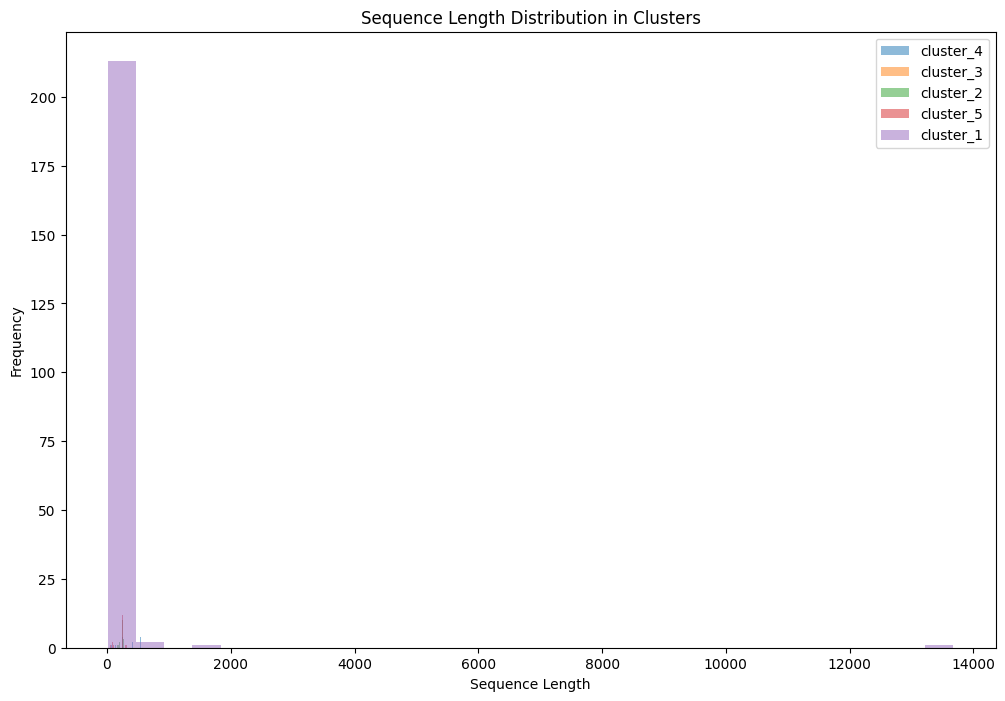

In [ ]:
# Define the path to the directory containing the clusters
clusters_dir = "/content/clustered_fastq"

# Initialize a dictionary to store sequence lengths for each cluster
cluster_lengths = {}

# Iterate through the subdirectories (clusters)
for cluster_name in os.listdir(clusters_dir):
    cluster_path = os.path.join(clusters_dir, cluster_name)
    if os.path.isdir(cluster_path):
        # Initialize a list to store sequence lengths for the current cluster
        lengths = []

        # Iterate through the files in the cluster
        for file_name in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, file_name)
            if os.path.isfile(file_path) and file_name.endswith(".fastq"):
                # Read the sequence length from the file and add it to the list
                with open(file_path, "r") as file:
                    lines = file.readlines()
                    seq_length = len(lines[1].strip())  # Assuming the sequence is on the second line
                    lengths.append(seq_length)

        # Store the sequence lengths for the current cluster
        cluster_lengths[cluster_name] = lengths

# Plot histograms for sequence lengths in each cluster
plt.figure(figsize=(12, 8))
for cluster_name, lengths in cluster_lengths.items():
    plt.hist(lengths, bins=30, alpha=0.5, label=cluster_name)

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution in Clusters')
plt.legend()
plt.show()

Cluster Padding

In [ ]:
def pad_sequences(input_file, output_file, target_length):
    with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
        lines = f_in.readlines()
        seq_id = None
        sequence = ''
        quality_scores = ''

        for line in lines:
            if line.startswith('@'):  # Sequence identifier line
                if seq_id is not None:
                    pad_length = target_length - len(sequence)
                    if pad_length > 0:
                        sequence = sequence.ljust(target_length, 'N')  # Pad with 'N'
                    f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')

                seq_id = line.strip()
                sequence = ''
                quality_scores = ''
            elif seq_id is not None:
                if line.startswith('+'):  # Quality identifier line
                    continue
                elif line.strip():  # Sequence or quality scores line
                    sequence += line.strip()

        # Write the last entry
        if seq_id is not None:
            pad_length = target_length - len(sequence)
            if pad_length > 0:
                sequence = sequence.ljust(target_length, 'N')  # Pad with 'N'
            f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')

# Example usage
input_file = 'input.fastq'
output_file = 'padded_output.fastq'
target_length = 150  # Target length for padding
pad_sequences(input_file, output_file, target_length)


Cluster Cutting

In [ ]:
def cut_to_min_length(input_file, output_file, min_length):
    ''' na krataw ta xarakthristika megethi twn clusters'''
    with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
        lines = f_in.readlines()
        seq_id = None
        sequence = ''
        quality_scores = ''

        for line in lines:
            if line.startswith('@'):  # Sequence identifier line
                if seq_id is not None:  # Write processed sequence and quality scores
                    f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')

                seq_id = line.strip()
                sequence = ''
                quality_scores = ''
            elif seq_id is not None:
                if line.startswith('+'):  # Quality identifier line
                    continue
                elif line.strip():  # Sequence or quality scores line
                    sequence += line.strip()

        # Write the last entry
        if seq_id is not None:
            if len(sequence) < min_length:
                sequence = sequence.ljust(min_length, 'N')  # Pad with 'N' below min length
            f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')


Meeting in the middle

In [ ]:
def cut_above_mean_pad_below(input_file, output_file, mean_length):
    with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
        lines = f_in.readlines()
        seq_id = None
        sequence = ''
        quality_scores = ''
        lengths = []

        for line in lines:
            if line.startswith('@'):  # Sequence identifier line
                if seq_id is not None:  # Process sequence length
                    lengths.append(len(sequence))

                seq_id = line.strip()
                sequence = ''
                quality_scores = ''
            elif seq_id is not None:
                if line.startswith('+'):  # Quality identifier line
                    continue
                elif line.strip():  # Sequence or quality scores line
                    sequence += line.strip()

        mean_length = sum(lengths) / len(lengths) if lengths else 0

        for line in lines:
            if line.startswith('@'):  # Sequence identifier line
                if seq_id is not None:
                    if len(sequence) > mean_length:
                        sequence = sequence[:mean_length]
                    else:
                        sequence = sequence.ljust(mean_length, 'N')  # Pad with 'N' below mean length
                    f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')

                seq_id = line.strip()
                sequence = ''
                quality_scores = ''
            elif seq_id is not None:
                if line.startswith('+'):  # Quality identifier line
                    continue
                elif line.strip():  # Sequence or quality scores line
                    quality_scores += line.strip()

        # Write the last entry
        if seq_id is not None:
            if len(sequence) > mean_length:
                sequence = sequence[:mean_length]
            else:
                sequence = sequence.ljust(mean_length, 'N')
            f_out.write(f'{seq_id}\n{sequence}\n+\n{quality_scores}\n')


## Make groups.

This part of the script creates a single cluster with sequences of exactly the same length.

In [8]:
def process_fastq_files(dataset_folder, target_length=300, output_folder="filtered_reads"):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through files and subfolders in dataset folder
    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(".fastq") or file.endswith(".fq"):
                file_path = os.path.join(root, file)
                process_fastq_file(file_path, target_length, output_folder)

def process_fastq_file(file_path, target_length, output_folder):
    output_file = os.path.join(output_folder, os.path.basename(file_path).replace(".fastq", "_filtered.fastq"))

    with open(output_file, "w") as out_handle:
        for record in SeqIO.parse(file_path, "fastq"):
            if len(record.seq) == target_length:
                SeqIO.write(record, out_handle, "fastq")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.6 MB/s eta 0:00:00


In [9]:
dataset_folder = "/content/fastq_dataset"
process_fastq_files(dataset_folder)

In [11]:
def zip_and_move(source_folder, dest_folder, zip_filename):
    # Create a zip file
    zip_file_path = os.path.join(dest_folder, zip_filename)
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, source_folder))

    # Move the zip file to the destination folder
    shutil.move(zip_file_path, os.path.join(dest_folder, zip_filename))

In [12]:
source_folder = "/content/filtered_reads"
dest_folder = "/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/DATA/DATASET"
zip_filename = "filtered_reads.zip"

zip_and_move(source_folder, dest_folder, zip_filename)